# Reproducing novel pulse usages in literature

In [1]:
import logging
import numpy as np
import h5py
import matplotlib.pyplot as plt
import rqutils.paulis as paulis
import qudit_sim

qudit_sim.config.jax_devices = [0, 1]
qudit_sim.config.num_cpus = 12

## siZZle (arXiv:2106.00675)

In [2]:
twopi = np.pi * 2.

hgen = qudit_sim.HamiltonianBuilder(4)
hgen.add_qudit(qubit_frequency=4.960e+9 * twopi, anharmonicity=-0.283e+9 * twopi, drive_amplitude=100.e+6 * twopi, qudit_id='q0')
hgen.add_qudit(qubit_frequency=5.016e+9 * twopi, anharmonicity=-0.287e+9 * twopi, drive_amplitude=100.e+6 * twopi, qudit_id='q1')
hgen.add_coupling('q0', 'q1', 7.745e+6 * twopi)

# Frame where the IZ component is zero in the qubit space when there is no drive
hgen.set_global_frame('noiz2')

### Figure 1(a)(b)

In [3]:
sizzle_frequency = 5.075e+9 * twopi

omega1s = np.linspace(0., 0.3, 10)

components_list = qudit_sim.apps.find_heff(hgen,
                                           qudit=('q0', 'q1'),
                                           frequency=(sizzle_frequency, sizzle_frequency),
                                           amplitude=[(-omega1 * 2., omega1) for omega1 in omega1s],
                                           comp_dim=2,
                                           min_fidelity=0.7,
                                           save_result_to='sizzle_ampscan')

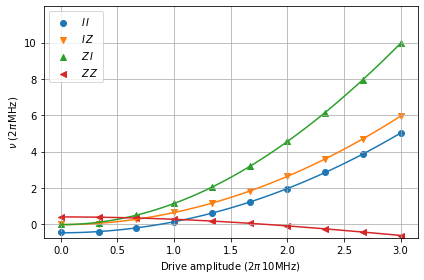

In [4]:
physical_amplitudes = omega1s * hgen.qudit_params('q1').drive_amplitude

selection = [(0, 0), (0, 3), (3, 0), (3, 3)]
_, coeffs, _, a_scale, c_scale = qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list, select_components=selection)

In [5]:
amplitudes_fine = np.linspace(0., physical_amplitudes[-1], 100)
norm_amps = amplitudes_fine / a_scale.pulsatance_value
pauli_coeffs = np.zeros((4, 4, coeffs[0].shape[0]))
pauli_coeffs[[0, 0, 3, 3], [0, 3, 0, 3]] = coeffs
components = np.sum(pauli_coeffs[..., None] * np.power(norm_amps[None, :], np.arange(5)[:, None]), axis=2) * c_scale.pulsatance_value
components = np.moveaxis(components, -1, 0)

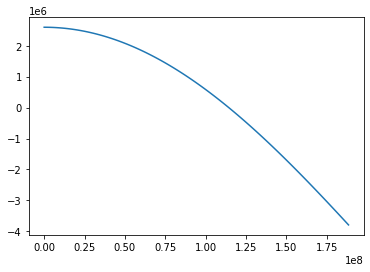

In [6]:
plt.plot(amplitudes_fine, components[:, 3, 3])

In [7]:
diagonals = paulis.compose(components, (2, 2)).real
eigvals = diagonals.reshape(-1, 16)[:, ::5]

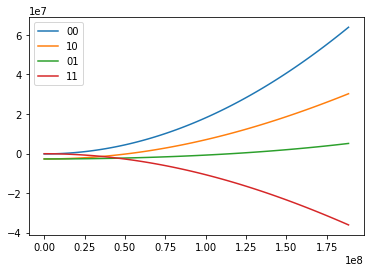

In [8]:
plt.plot(amplitudes_fine, eigvals, label=['00', '10', '01', '11'])
plt.legend();

### Figure 1(c)(d)

In [9]:
sizzle_frequency = 5.075e+9 * twopi

dphis = np.linspace(0., twopi, 10)
omega1 = 0.2

components_list = qudit_sim.apps.find_heff(hgen,
                                           qudit=('q0', 'q1'),
                                           frequency=(sizzle_frequency, sizzle_frequency),
                                           amplitude=[(2. * omega1 * np.exp(1.j * dphi), omega1) for dphi in dphis],
                                           comp_dim=2,
                                           min_fidelity=0.7,
                                           save_result_to='sizzle_phasescan')

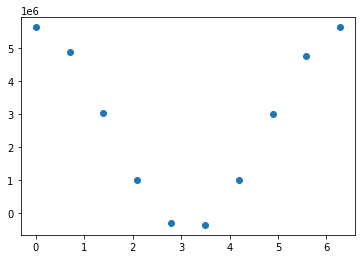

In [10]:
nzz = np.array([comp[3, 3] for comp in components_list])
plt.scatter(dphis, nzz)

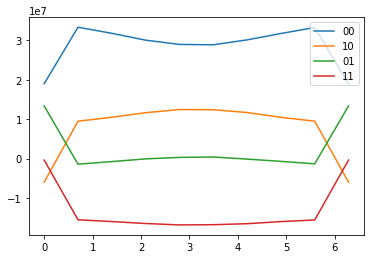

In [11]:
components_list = np.array(components_list)
components = np.zeros((4, 4) + dphis.shape)
components[[0, 0, 3, 3], [0, 3, 0, 3]] = np.moveaxis(components_list, 0, -1)[[0, 0, 3, 3], [0, 3, 0, 3]]
components = np.moveaxis(components, -1, 0)
diagonals = paulis.compose(components, (2, 2)).real
eigvals = diagonals.reshape(-1, 16)[:, ::5]
plt.plot(dphis, eigvals, label=['00', '10', '01', '11'])
plt.legend();

## Cross-cross-resonance (arXiv:2103.00024)

In [12]:
hgen = qudit_sim.HamiltonianBuilder(4)
hgen.add_qudit(qubit_frequency=4.858e+9 * twopi, anharmonicity=-0.324e+9 * twopi, drive_amplitude=100.e+6 * twopi, qudit_id='q3')
hgen.add_qudit(qubit_frequency=4.978e+9 * twopi, anharmonicity=-0.338e+9 * twopi, drive_amplitude=100.e+6 * twopi, qudit_id='q4')
hgen.add_coupling('q3', 'q4', 1.4e+6 * twopi)

# Frame where the IZ component is zero in the qubit space when there is no drive
hgen.set_global_frame('noiz2')

In [13]:
eigenvalues = hgen.eigenvalues()
q3_frequency = np.mean(eigenvalues[1, :2] - eigenvalues[0, :2])
q4_frequency = np.mean(eigenvalues[:2, 1] - eigenvalues[:2, 0])

components = qudit_sim.apps.find_heff(hgen,
                                      qudit=('q3', 'q4'),
                                      frequency=(q4_frequency, q3_frequency),
                                      amplitude=(0.2, 0.2),
                                      comp_dim=2,
                                      min_fidelity=0.7,
                                      save_result_to='ccr')

In [14]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

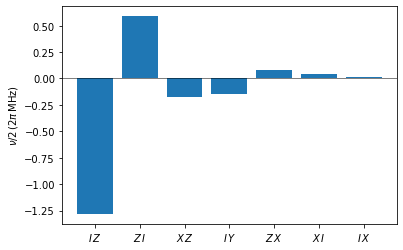

In [15]:
qudit_sim.visualization.plot_components(components);

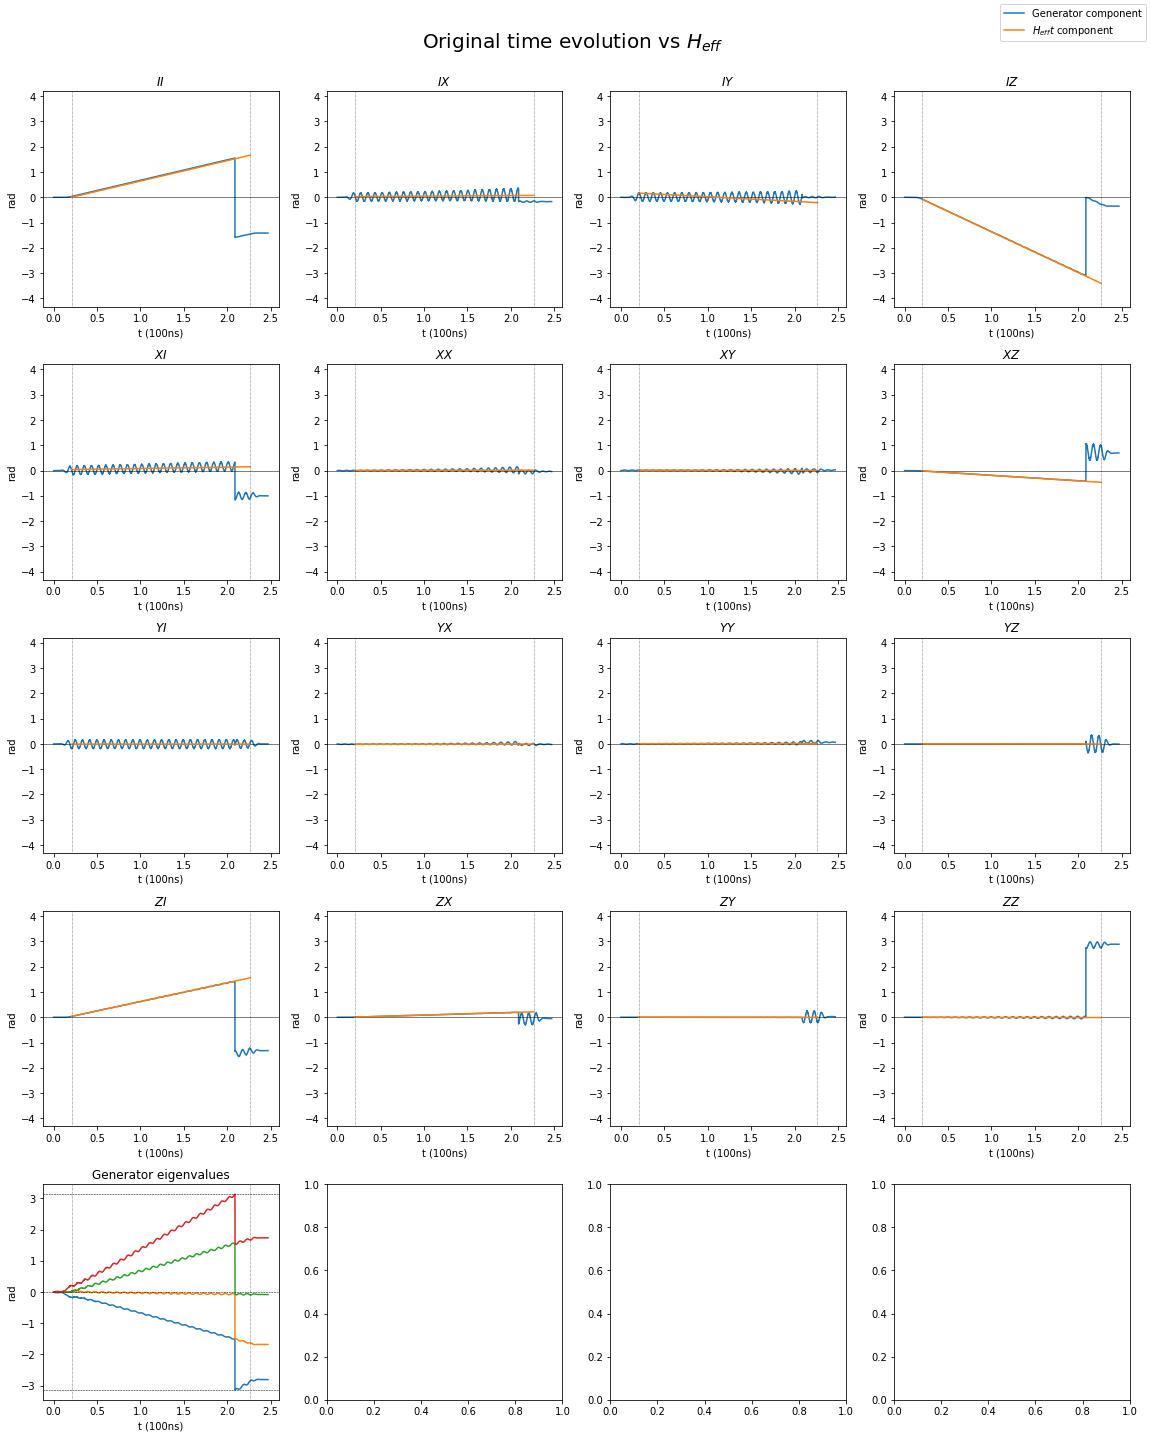

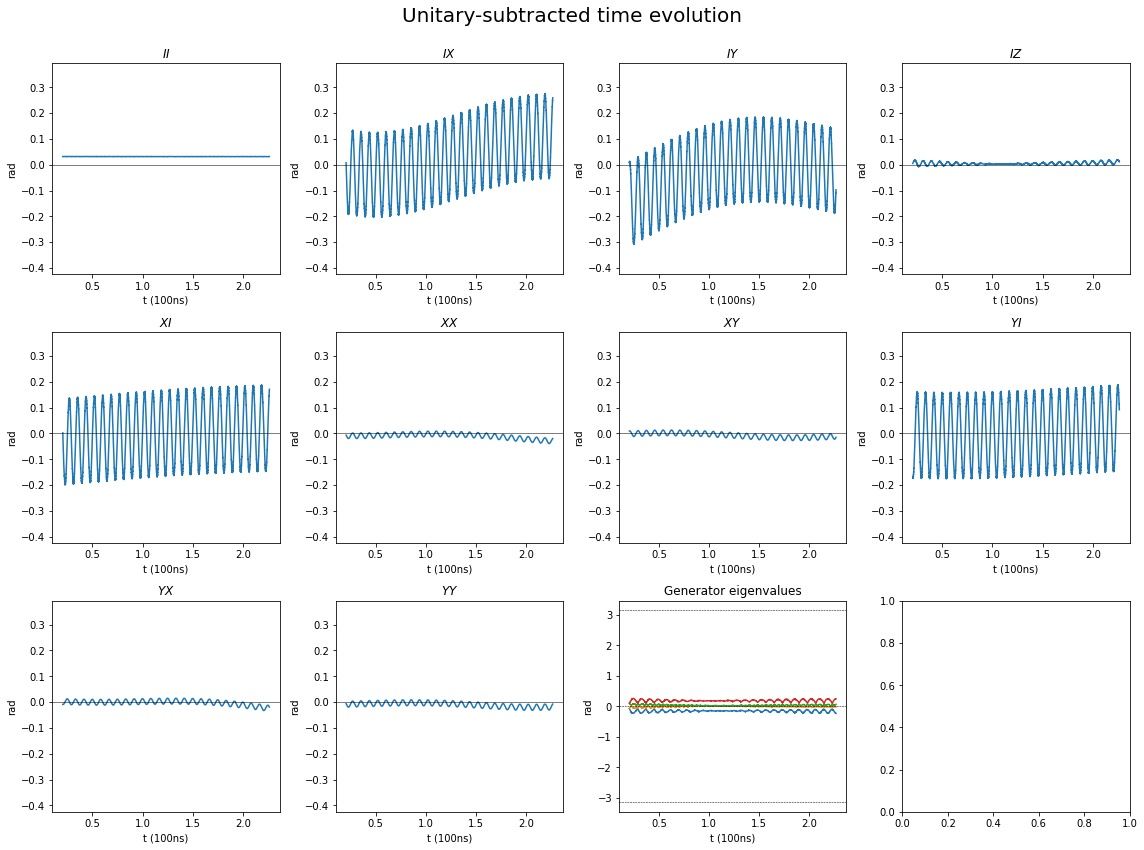

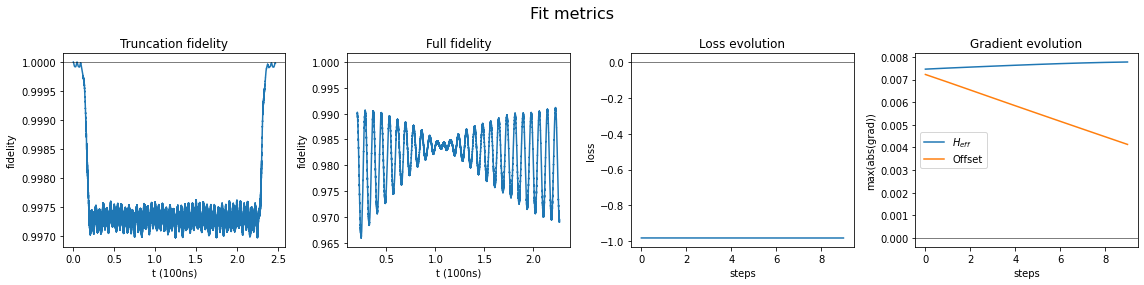

In [16]:
qudit_sim.visualization.inspect_heff_fit('ccr.h5');